In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from tensorflow import keras
import astropy 
import scipy
from PIL import Image
import cv2

#Get Trainingdata from Sample File with Cluster Images

In [4]:
#np_load_old = np.load
#np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True)
#np.load.__defaults__=(None, True, True, 'ASCII')
data = np.load('imagedata.npy')#, allow_pickle=True)
# i=10
print(data.shape)
print(data[0])

#while i<5:
#    print(data[np.random.randint(0,1000)].shape)
#    fig=plt.figure()
#    plt.imshow(data[np.random.randint(0,1000)], cmap='gray',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))
#    plt.colorbar()
#    plt.show()
#    i=i+1

(3867,)
[[0.00074822 0.00091118 0.00124928 0.00155778 0.00193843 0.00219098
  0.00228025 0.00219098 0.00193843 0.00155778 0.00124928 0.00091118
  0.00074822]
 [0.00079761 0.00108164 0.00144448 0.00191264 0.00234257 0.00302481
  0.00327889 0.00302481 0.00234257 0.00191264 0.00144448 0.00108164
  0.00079761]
 [0.0008399  0.00122962 0.00166807 0.00223596 0.0032345  0.00448163
  0.00543525 0.00448163 0.0032345  0.00223596 0.00166807 0.00122962
  0.0008399 ]
 [0.00092839 0.00135099 0.00189715 0.00273541 0.00446112 0.00765115
  0.00959851 0.00765115 0.00446112 0.00273541 0.00189715 0.00135099
  0.00092839]
 [0.00100505 0.00144158 0.00207152 0.00326156 0.00657433 0.01182537
  0.01294876 0.01182537 0.00657433 0.00326156 0.00207152 0.00144158
  0.00100505]
 [0.00105208 0.00149767 0.00218121 0.00360272 0.00840935 0.01361496
  0.01899725 0.01361496 0.00840935 0.00360272 0.00218121 0.00149767
  0.00105208]
 [0.00106794 0.00151667 0.00221871 0.00372152 0.00924791 0.01478263
  0.39600781 0.01478263 

In [ ]:
#data is in varying shape, need to get it into unified shape: 256x256

In [6]:
#lastimage = data.shape[0]
#print(lastimage)

j=0 
resizedimages = []
while j< 3000: #lastimage
    #print(data[j])
    img = data[j]
    imgsave = np.array(cv2.resize(img,dsize=(28,28), interpolation=cv2.INTER_NEAREST))
    #plt.figure()
    #plt.imshow(img,cmap='gray',norm=cm.colors.LogNorm(vmin=3e-7,vmax=10.5))
    #plt.show()
    del(img)
    #print(np.array(imgsave))
    resizedimages.append(imgsave)
    j=j+1

bugfix = False
if bugfix:
    print(data[0])
    fig=plt.figure()
    plt.imshow(data[1], cmap='gray',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))
    plt.title('without resizing')
    plt.colorbar()
    plt.show()
    #del(data)
    #print(resizedimages[[0]].shape)

    #plot a few images to see if they are correct
i=10
while i<10:
    #print(resizedimages[np.random.randint(0,10)].shape)
    #print(resizedimages[0])
    fig=plt.figure()
    plt.title('with resizing')
    plt.imshow(resizedimages[i], cmap='gray',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))
    plt.colorbar()
    plt.show()
    i=i+1    
        


Now define a discriminator network 

In [7]:
def define_discriminator(in_shape=(28,28,1)):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def generate_fake_samples(n_samp):
    n_samp = int(n_samp)
    fakes = np.random.rand((28*28*n_samp))
    y = np.zeros((n_samp,1))
    fakes = fakes.reshape((n_samp,28,28,1))
    return  fakes, y
    
def generate_real_samples(dataset, n_samples):
    # choose random instances
    n_samples = int(n_samples)
    lendata = int(len(dataset))
    ix = np.random.randint(0, lendata, n_samples)
    dataset = np.array(dataset)
    # retrieve selected images
    X = dataset[ix]
    X = np.expand_dims(X, axis = -1)
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y
    
def train_discriminator(model, dataset, n_iter=10,n_batch=200):
    for i in range(n_iter):
        batchhalf = n_batch/2
        X_real,y_real = generate_real_samples(dataset,batchhalf)
        #print(X_real,y_real)
        print(X_real.shape)
        _,real_acc = model.train_on_batch(X_real,y_real)
        X_fake, y_fake = generate_fake_samples(batchhalf)
        _,fake_acc = model.train_on_batch(X_fake,y_fake)
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
        
dataset = resizedimages 
model = define_discriminator()
model.summary()
#train_discriminator(model,dataset)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
__________________________________________

Some thoughts on size of deconvolution output: 
from https://stackoverflow.com/questions/35980044/getting-the-output-shape-of-deconvolution-layer-using-tf-nn-conv2d-transpose-in: output_size = strides * (input_size-1) + kernel_size - 2*padding 
why?

so to get 28x28: 28x28 = 2x2 \bigotimes (13x13) + 1x1

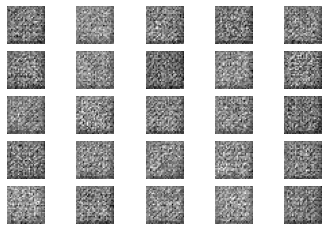

(28, 28)


In [8]:
#build and train generator
# define the standalone generator model
def define_generator(latent_dim):
    model = keras.models.Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(keras.layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()
print(X[1,:,:,0].shape)

now define the GAN and train it 

In [9]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = keras.models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=2):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    #save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=500):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = np.array(resizedimages)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/6, d=0.713, g=0.678
>1, 2/6, d=0.703, g=0.701
>1, 3/6, d=0.693, g=0.728
>1, 4/6, d=0.681, g=0.748
>1, 5/6, d=0.669, g=0.770
>1, 6/6, d=0.656, g=0.797
>2, 1/6, d=0.649, g=0.822
>2, 2/6, d=0.638, g=0.843
>2, 3/6, d=0.632, g=0.863
>2, 4/6, d=0.626, g=0.876
>2, 5/6, d=0.627, g=0.868
>2, 6/6, d=0.634, g=0.846
>3, 1/6, d=0.646, g=0.809
>3, 2/6, d=0.659, g=0.770
>3, 3/6, d=0.669, g=0.743
>3, 4/6, d=0.675, g=0.726
>3, 5/6, d=0.679, g=0.714
>3, 6/6, d=0.682, g=0.708
>4, 1/6, d=0.684, g=0.704
>4, 2/6, d=0.685, g=0.701
>4, 3/6, d=0.685, g=0.699
>4, 4/6, d=0.686, g=0.697
>4, 5/6, d=0.685, g=0.696
>4, 6/6, d=0.685, g=0.695
>5, 1/6, d=0.685, g=0.694
>5, 2/6, d=0.686, g=0.694
>5, 3/6, d=0.685, g=0.693
>5, 4/6, d=0.685, g=0.693
>5, 5/6, d=0.685, g=0.693
>5, 6/6, d=0.684, g=0.692
>6, 1/6, d=0.684, g=0.692
>6, 2/6, d=0.683, g=0.692
>6, 3/6, d=0.683, g=0.693
>6, 4/6, d=0.683, g=0.693
>6, 5/6, d=0.682, g=0.693
>6, 6/6, d=0.681, g=0.693
>7, 1/6, d=0.681, g=0.694
>7, 2/6, d=0.681, g=0.694
>7, 3/6, d=0

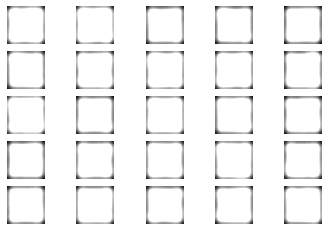

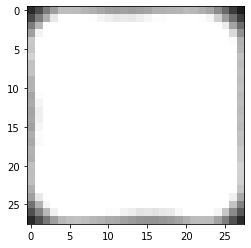

In [12]:
#predict some images
# generate samples
n_samples = 25
generator = keras.models.load_model('generator_model_020.h5')
X, _ = generate_fake_samples(generator, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis labels
    plt.axis('off')
    # plot single image
    plt.imshow(X[i, :, :, 0], cmap='gray_r',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))
# show the figure
plt.show()
plt.imshow(X[1,:,:,0], cmap='gray_r',norm=cm.colors.LogNorm(vmin=3e-7,vmax=0.025))